### Intro. 패키지 설치 및 import

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (4,789 kB/s)
debconf: unable to initialize fronten

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 1,051 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-kor all 1:4.00~git30-7274cfa-1 [1,051 kB]
Fetched 1,051 kB in 1s (1,465 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling b

In [ ]:
# 사용 가능한 언어 확인
!tesseract --list-langs

List of available languages (3):
eng
kor
osd


In [ ]:
from PIL import Image
from google.colab.patches import cv2_imshow
import pytesseract as tesseract
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 소이 파크

### 1) 이미지 로드

* OpenCV는 기본적으로 이미지를 BGR타입으로 읽음
* Matplotlib등 대부분의 이미지 라이브러리는 RGB타입을 사용
* 따라서 BGR -> RGB 변경

(1600, 1236, 3)


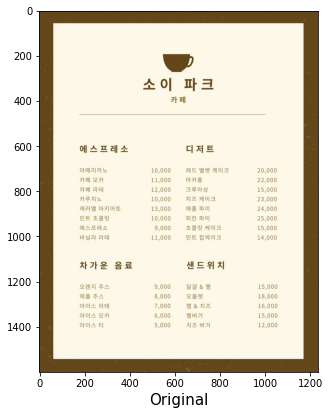

In [ ]:
image_bgr = cv2.imread("/content/drive/MyDrive/Solution-Challenge/image/test.jpeg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=[5, 15])
plt.imshow(image)
plt.xlabel("Original", fontsize = 15)
print(image.shape)

### 2) Color -> GrayScale

image shape:  (1600, 1236, 3)
Graysacle image shape:  (1600, 1236)


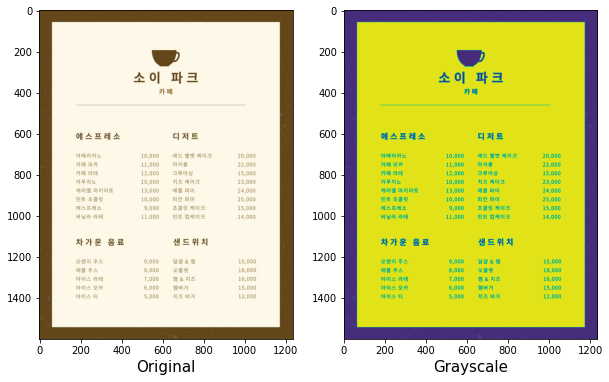

In [ ]:
def gray_scale(image):
    result = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return result

image_gray = gray_scale(image)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel("Original", fontsize = 15)
print("image shape: ", image.shape)
plt.subplot(1, 2, 2)
plt.imshow(image_gray)
plt.xlabel("Grayscale", fontsize = 15)
print("Graysacle image shape: ", image_gray.shape)

### 3) 이미지 확대하기

Text(0.5, 0, 'Large_Grayscale')

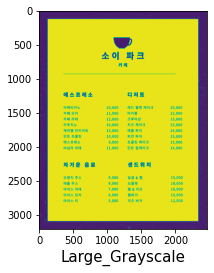

In [ ]:
height, width = image_gray.shape
gray_enlarge = cv2.resize(image_gray, (2 * width, 2 * height), interpolation=cv2.INTER_LINEAR)
plt.imshow(gray_enlarge)
plt.xlabel("Large_Grayscale", fontsize = 15)

### 3-2) 이미지 대비 증가

Text(0.5, 1.0, 'Enhanced Image')

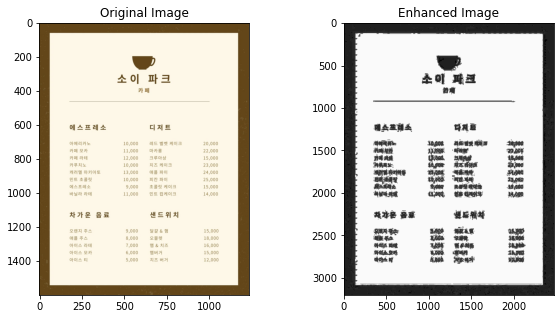

In [ ]:
"""
# 이미지 대비를 향상
image_enhanced = cv2.equalizeHist(gray_enlarge)

# plot
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_enhanced, cmap='gray')
ax[1].set_title('Enhanced Image')
"""

### 4) 노이즈 제거하기

Text(0.5, 1.0, 'Enhanced Image')

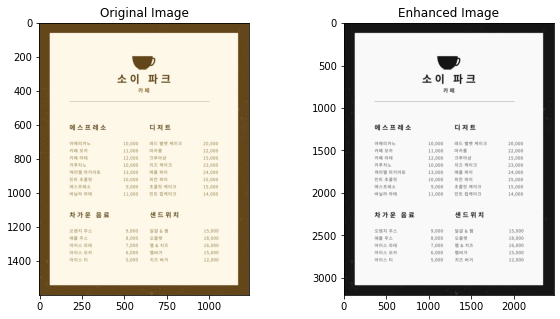

In [ ]:
# Denoising
denoised = cv2.fastNlMeansDenoising(gray_enlarge, h=10, searchWindowSize=21, templateWindowSize=7)

# plot
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(denoised, cmap='gray')
ax[1].set_title('Enhanced Image')

### 4-2) 블러처리로 노이즈 제거
* kernel_size 값이 커질수록 이미지가 뭉개짐

image shape:  (1600, 1236, 3)


Text(0.5, 0, 'Noise removed')

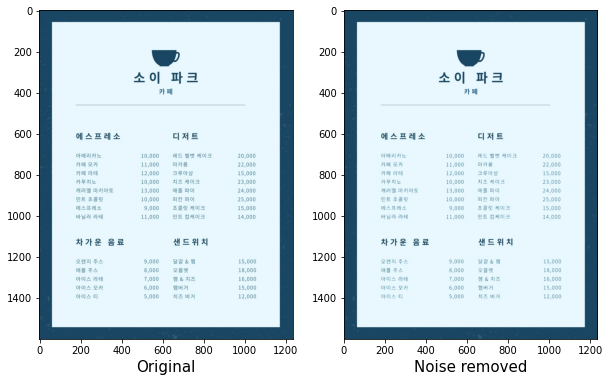

In [ ]:
def remove_noise(image, kernel_size = 3):
    result = cv2.medianBlur(image, ksize = kernel_size)
    return result

image_rm = remove_noise(image)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel("Original", fontsize = 15)
print("image shape: ", image.shape)
plt.subplot(1, 2, 2)
plt.imshow(image_rm)
plt.xlabel("Noise removed", fontsize = 15)

### 5) 이진화 (best)

In [ ]:
# Adaptive Thresholding 적용 
max_output_value = 255   # 출력 픽셀 강도의 최대값
neighborhood_size = 99
subtract_from_mean = 10
image_binarized = cv2.adaptiveThreshold(denoised,
                                       max_output_value,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY,
                                       neighborhood_size,
                                       subtract_from_mean)

### 5-2) 이진화 (case-by-case)

In [ ]:
# Thresholding
gray_pin = 196  # 회색 인지 정도
ret, thresh = cv2.threshold(denoised, gray_pin, 255, cv2.THRESH_BINARY)

# inverting
thresh[260:2090] = ~thresh[260:2090]

dst = "/content/drive/MyDrive/result_compare.jpeg"
result = thresh

cv2.imwrite(dst, result)

result = "/content/drive/MyDrive/result_compare.jpeg"
print(tesseract.image_to_string(Image.open("/content/drive/MyDrive/result_compare.jpeg"), lang='kor'))

### 5-3) 이진화 (GrayScale -> Binary)

Graysacle image shape:  (1600, 1236)
[[74 74 74 ... 74 74 74]
 [74 74 74 ... 74 74 74]
 [74 74 74 ... 74 74 74]
 ...
 [74 74 74 ... 74 74 74]
 [74 74 74 ... 74 74 74]
 [74 74 74 ... 74 74 74]] 

Binary image shape:  (1600, 1236)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


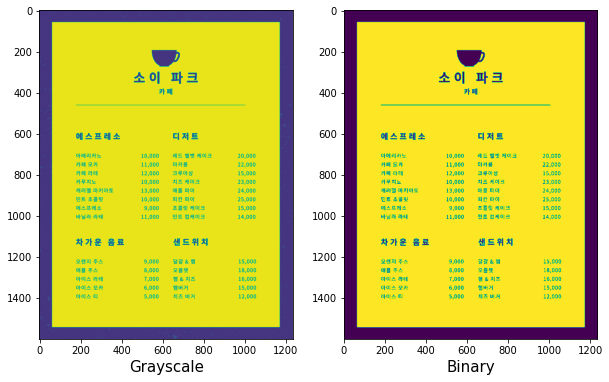

In [ ]:
def image_threshold(image):
    result = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return result

image_binary = image_threshold(image_gray)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image_gray)
plt.xlabel("Grayscale", fontsize = 15)
print("Graysacle image shape: ", image_gray.shape)
print(image_gray, "\n")
plt.subplot(1, 2, 2)
plt.imshow(image_binary)
plt.xlabel("Binary", fontsize = 15)
print("Binary image shape: ", image_binary.shape)
print(image_binary)

### 6) 결과 출력

In [ ]:
dst = "/content/drive/MyDrive/Solution-Challenge/result/result_best.jpeg"
result = image_binarized

cv2.imwrite(dst, result)

result = "/content/drive/MyDrive/Solution-Challenge/result/result_best.jpeg"
print(tesseract.image_to_string(Image.open("/content/drive/MyDrive/Solution-Challenge/result/result_best.jpeg"), lang='kor'))

에스프레소

아메리카노
카페 모카

카페 라테
카푸치노

캐러멜 마키아토
민트 초콜릿
에스프레소

바닐라 라테

아이스 라테
아이스 모카
아이스 티

디저트

레드 벨벳 케이크
마카롱

크루아상

치즈 케이크
애플 파이

피칸 파이
초콜릿 케이크
민트 컵케이크

샌드위치
달갈 & 햄
오물렛

햄 & 치즈
햄버거

치즈 버거

15,000
18,000
16000
15,000
12000

 



## 2. Test2 -> 한국어와 영어 혼용

(992, 1403, 3)


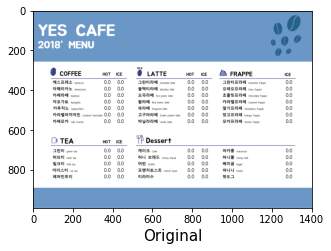

In [ ]:
image2 = cv2.imread("/content/drive/MyDrive/Solution-Challenge/image/test2.png", cv2.IMREAD_COLOR)
plt.figure(figsize=[5, 15])
plt.imshow(image2)
plt.xlabel("Original", fontsize = 15)
print(image2.shape)

image2 shape:  (992, 1403, 3)
Graysacle image shape:  (992, 1403)


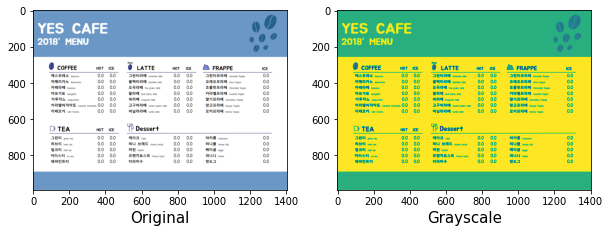

In [ ]:
image2_gray = gray_scale(image2)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image2)
plt.xlabel("Original", fontsize = 15)
print("image2 shape: ", image2.shape)
plt.subplot(1, 2, 2)
plt.imshow(image2_gray)
plt.xlabel("Grayscale", fontsize = 15)
print("Graysacle image shape: ", image2_gray.shape)

Text(0.5, 0, 'Large_Grayscale')

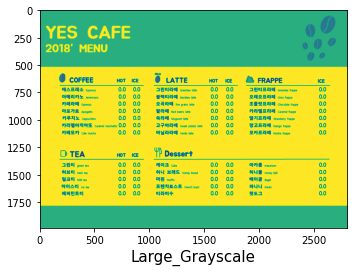

In [ ]:
height, width = image2_gray.shape
gray2_enlarge = cv2.resize(image2_gray, (2 * width, 2 * height), interpolation=cv2.INTER_LINEAR)
plt.imshow(gray2_enlarge)
plt.xlabel("Large_Grayscale", fontsize = 15)

Text(0.5, 1.0, 'Enhanced Image')

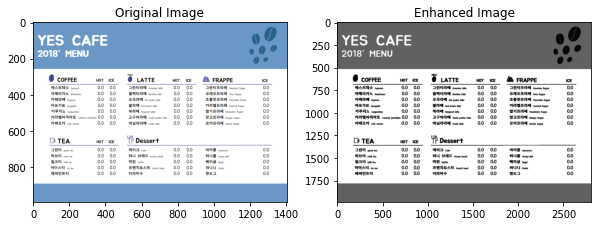

In [ ]:
"""
# 이미지 대비를 향상
image2_enhanced = cv2.equalizeHist(gray2_enlarge)

# plot
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(image2, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image2_enhanced, cmap='gray')
ax[1].set_title('Enhanced Image')
"""

In [ ]:
# Denoising
denoised2 = cv2.fastNlMeansDenoising(gray2_enlarge, h=10, searchWindowSize=21, templateWindowSize=7)

In [ ]:
# Adaptive Thresholding 적용 
max_output_value = 255   # 출력 픽셀 강도의 최대값
neighborhood_size = 99
subtract_from_mean = 10
image2_binarized = cv2.adaptiveThreshold(denoised2,
                                       max_output_value,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY,
                                       neighborhood_size,
                                       subtract_from_mean)

In [ ]:
dst2 = "/content/drive/MyDrive/Solution-Challenge/result/result2_best.jpeg"
result2 = image2_binarized

cv2.imwrite(dst2, result2)

result = "/content/drive/MyDrive/Solution-Challenge/result/result2_best.jpeg"
print(tesseract.image_to_string(Image.open("/content/drive/MyDrive/Solution-Challenge/result/result2_best.jpeg"), lang='kor'))

버크) (선유
0000 0310

@ 600다ㄷㄷ          107
에스프레소 60650         0.0
아메리카노 새에000         0.0
카페라떼 60650          0.0
아포가토 090            0.0
카푸치노 00000400          0.0
카라멜마끼아또 0000 00010 0.0
카페모카 (366 07002             0.0
0 164ㅅ^            107
그린티 00020           0.0
허브티 8 벼           0.0
밀크티 내           0.0
아이스티 \녀          0.0
페퍼민트티               0.0

1

0.0
0.0
0.0
0.0
0.0

@ Ｌㄴㅅ7ㅠㄷ

그린티라떼 (60600663 13006
블랙티라떼 00060 104
오곡라떼 106 91305 1006
팔라떼 60 60010

쑥라떼 10940

고구마라떼 66020 1000
바닐라라떼 \ 00 000

바 06556}

케이크 0%
허니 브레드 10 66000
머핀 처
프렌치토스트 타아0

티라미수

0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0

스 타사
그린티프라페  600001603 02006
오레오프라페 0060 03006
초콜릿프라페 아00036 60000
카라멜프라페  (63027 72006
딸기프라페에 60000
망고프라펠 0090 00000
모카프라페 "000 5000

마카롱 000
허니볼 10% 81
베이글 609
파니 니  『300
핫도그

 

0.0
0.0
0.0
0.0
0.0

 



## 3. Test 3 -> 기울어짐

(800, 800, 3)


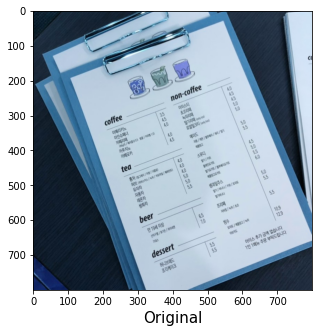

In [ ]:
image3 = cv2.imread("/content/drive/MyDrive/Solution-Challenge/image/test3.jpeg", cv2.IMREAD_COLOR)
plt.figure(figsize=[5, 15])
plt.imshow(image3)
plt.xlabel("Original", fontsize = 15)
print(image3.shape)

image2 shape:  (800, 800, 3)
Graysacle image shape:  (800, 800)


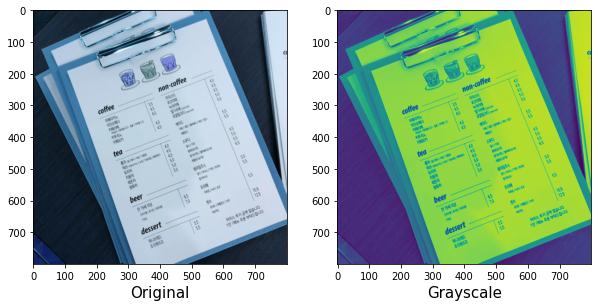

In [ ]:
image3_gray = gray_scale(image3)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image3)
plt.xlabel("Original", fontsize = 15)
print("image2 shape: ", image3.shape)
plt.subplot(1, 2, 2)
plt.imshow(image3_gray)
plt.xlabel("Grayscale", fontsize = 15)
print("Graysacle image shape: ", image3_gray.shape)

Text(0.5, 0, 'Large_Grayscale')

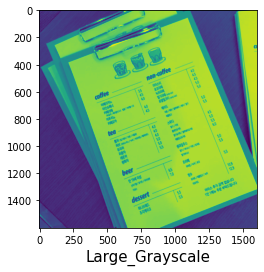

In [ ]:
height, width = image3_gray.shape
gray3_enlarge = cv2.resize(image3_gray, (2 * width, 2 * height), interpolation=cv2.INTER_LINEAR)
plt.imshow(gray3_enlarge)
plt.xlabel("Large_Grayscale", fontsize = 15)

In [ ]:
# Denoising
denoised3 = cv2.fastNlMeansDenoising(gray3_enlarge, h=10, searchWindowSize=21, templateWindowSize=7)

In [ ]:
# Adaptive Thresholding 적용 
max_output_value = 255   # 출력 픽셀 강도의 최대값
neighborhood_size = 99
subtract_from_mean = 10
image3_binarized = cv2.adaptiveThreshold(denoised3,
                                       max_output_value,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY,
                                       neighborhood_size,
                                       subtract_from_mean)

In [ ]:
dst3 = "/content/drive/MyDrive/Solution-Challenge/result/result3_best.jpeg"
result3 = image3_binarized

cv2.imwrite(dst3, result3)

result = "/content/drive/MyDrive/Solution-Challenge/result/result3_best.jpeg"
print(tesseract.image_to_string(Image.open("/content/drive/MyDrive/Solution-Challenge/result/result3_best.jpeg"), lang='kor'))

## 4. Test 4 -> 배경에 그림 있음

In [94]:
image4 = cv2.imread("/content/drive/MyDrive/Solution-Challenge/image/test4.jpeg", cv2.IMREAD_COLOR)

image4_gray = gray_scale(image4)

height, width = image4_gray.shape
gray4_enlarge = cv2.resize(image4_gray, (2 * width, 2 * height), interpolation=cv2.INTER_LINEAR)

# Denoising
denoised4 = cv2.fastNlMeansDenoising(gray4_enlarge, h=10, searchWindowSize=21, templateWindowSize=7)

# Adaptive Thresholding 적용 
max_output_value = 255   # 출력 픽셀 강도의 최대값
neighborhood_size = 99
subtract_from_mean = 10
image4_binarized = cv2.adaptiveThreshold(denoised4,
                                       max_output_value,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY,
                                       neighborhood_size,
                                       subtract_from_mean)

dst4 = "/content/drive/MyDrive/Solution-Challenge/result/result4_best.jpeg"
result4 = image4_binarized

cv2.imwrite(dst4, result4)

result = "/content/drive/MyDrive/Solution-Challenge/result/result4_best.jpeg"
print(tesseract.image_to_string(Image.open("/content/drive/MyDrive/Solution-Challenge/result/result4_best.jpeg"), lang='kor'))

 

(73 언[9

여고
이 262     3.5/4.0
카페라띠)         3.8/4.3)
데드         3.8/4.3)
    0005
그린티라띠펠4.0/4.5,

아그
=
|

벼8

『「3006@

1

개 트비기!      5.0)

2드6          50

내     ~ 、
,         *
】                  느       )
~ 개            /          ^
^ ~    타투                   …
『             [|    느

트

/ ~     -
개 시 나즈 가
% 뜨 ~.    2     - 2

테솔 이       「

^
|     고
리히:   ^    5.   트 _ ㅋㅜ

시 '

}

뽀

~.   2    조
~ 틱~
티
6        …
「

1
은 이튼]

벨벳케이크

0000

 



## 그 외 보정 기법

### * Dilation(팽창)
* 이미지의 각 부분에 커널을 적용하여 커널과 일치하는 부분에 하나라도 0이 있으면 해당 부분을 채우는 방식

Text(0.5, 0, 'Dilation')

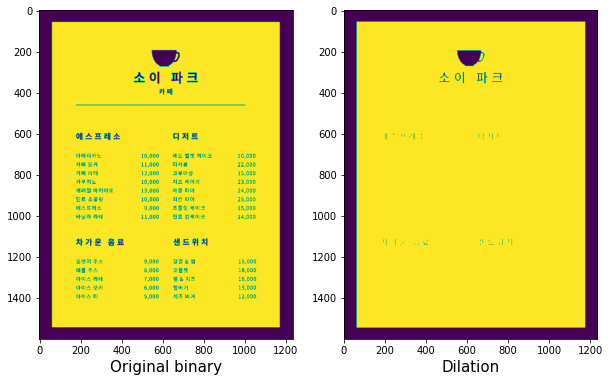

In [ ]:
def dilation(image):
    kernel = np.ones((5, 5), np.uint8)
    result = cv2.dilate(image, kernel, iterations = 1)
    return result

image_dilate = dilation(image_binary)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image_binary)
plt.xlabel("Original binary", fontsize = 15)
plt.subplot(1, 2, 2)
plt.imshow(image_dilate)
plt.xlabel("Dilation", fontsize = 15)

### * Erosion(침식)
* 이미지의 각 부분에 커널을 적용하여 커널과 일치하는 부분에 한개라도 0이 있으면 커널과 겹치는 부분을 모두 제거하는 방식

Text(0.5, 0, 'Erosion')

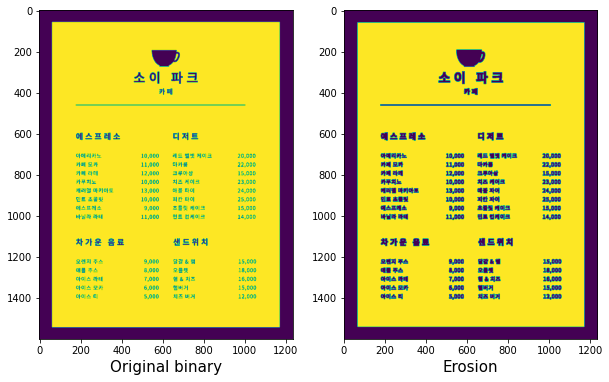

In [ ]:
def erosion(image):
    kernel = np.ones((5, 5), np.uint8)
    result = cv2.erode(image, kernel, iterations = 1)
    return result

image_erosion = erosion(image_binary)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image_binary)
plt.xlabel("Original binary", fontsize = 15)
plt.subplot(1, 2, 2)
plt.imshow(image_erosion)
plt.xlabel("Erosion", fontsize = 15)

### * Opening (Erosion -> Dilation)
* erosion 적용 후 dilation을 적용
* 잡티나 작게 튀어나온 것들을 제거하는 것에 적합

Text(0.5, 0, 'Opening')

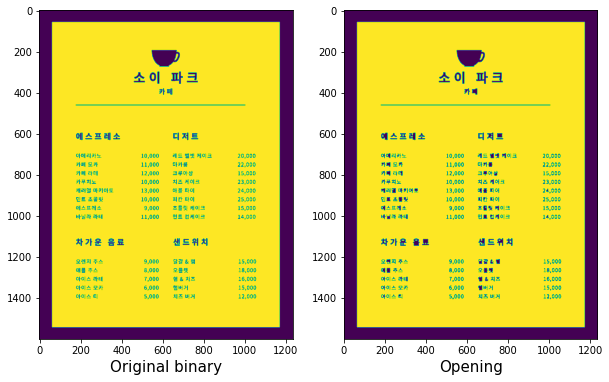

In [ ]:
def opening(image):
    kernel = np.ones((5, 5), np.uint8)
    result = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return result

image_open = opening(image_binary)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image_binary)
plt.xlabel("Original binary", fontsize = 15)
plt.subplot(1, 2, 2)
plt.imshow(image_open)
plt.xlabel("Opening", fontsize = 15)

### * Closing (Dilation -> Erosion)
* Dilation 적용 후 Erosion을 적용
* 전체적인 윤곽을 도드라지게 하는 효과

Text(0.5, 0, 'Closing')

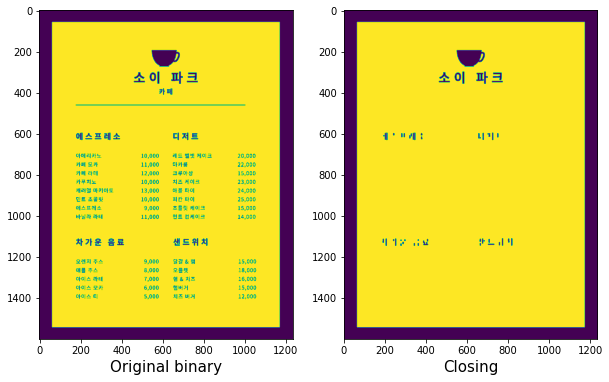

In [ ]:
def closing(image):
    kernel = np.ones((5, 5), np.uint8)
    result = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return result

image_close = closing(image_binary)

plt.figure(figsize=[10, 15])
plt.subplot(1, 2, 1)
plt.imshow(image_binary)
plt.xlabel("Original binary", fontsize = 15)
plt.subplot(1, 2, 2)
plt.imshow(image_close)
plt.xlabel("Closing", fontsize = 15)

### * 이미지의 수평보정
* 허프변환 : 영상내에서 직선을 검출하는 대표적 알고리즘 중 하나로 Opencv에서 제공

In [ ]:
mser = cv2.MSER_create()
regions, _ = mser.detectRegions(src_transform)

hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

for j, cnt in enumerate(hulls):
    x, y, w, h = cv2.boundingRect(cnt)

    if w > 160:
        continue

    cv2.rectangle(dst, (x, y), (x + w, y + h), (0, 255, 0), 1)

cv2.imwrite(image, dst)

NameError: ignored